# 單類型 無勢井 固定容器 彈性碰撞 MD

In [1]:
import numpy as np
import os
from scipy.spatial.distance import cdist

# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m = 1  # 分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 1000  # 模擬步數
r = 0.5  # 分子半徑
kb = 1.38e-23  # Boltzmann 常數

# 初始化分子位置和速度
# 使用規則網格排列初始化分子位置
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.array([[x * d - L / 2 + d / 2, y * d - L / 2 + d / 2, z * d - L / 2 + d / 2]
                for x in range(n) for y in range(n) for z in range(n)])[:N]
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 11*10
# 調整速度分佈,使總動量為零
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義碰撞函數


def elastic_collision(v1, v2, m1=m, m2=m):
    """求解兩個分子的碰撞後速度"""
    v1_new = v1 - (2 * m2 / (m1 + m2)) * np.dot(v1 - v2, v1 - v2) / \
        np.linalg.norm(v1 - v2) ** 2 * (v1 - v2)
    v2_new = v2 - (2 * m1 / (m1 + m2)) * np.dot(v2 - v1, v2 - v1) / \
        np.linalg.norm(v2 - v1) ** 2 * (v2 - v1)
    return v1_new, v2_new


# 模擬分子運動並輸出資料
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

with open('molecular_dynamics/data.xyz', 'w') as f:
    for step in range(num_steps):
        # 更新分子位置
        pos += vel * dt

        # 處理邊界碰撞
        mask = np.abs(pos) > L / 2 - r
        vel[mask] = -vel[mask]
        pos[mask] = np.sign(pos[mask]) * (L / 2 - r)

        # 處理分子間碰撞
        distances = cdist(pos, pos)
        for i in range(N):
            for j in range(i + 1, N):
                if distances[i, j] < 2 * r:
                    vel[i], vel[j] = elastic_collision(vel[i], vel[j])

        # 輸出 XYZ 格式的資料
        f.write(f"{N}\nFrame {step}\n")
        for i in range(N):
            f.write(f"Ar {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

In [4]:
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 11*10

vel -= np.sum(vel, axis=0)/ N

# 雙類型 無勢井 固定容器 彈性碰撞 MD

In [14]:
import numpy as np
import os
from scipy.spatial.distance import cdist

# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m1 = 1    # 第一種分子質量
m2 = 20    # 第二種分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 1000  # 模擬步數
r1 = 0.5  # 第一種分子半徑
r2 = 0.7  # 第二種分子半徑
kb = 1.38e-23  # Boltzmann 常數

# 初始化分子位置和速度
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.zeros((N, 3))
vel = np.random.normal(0, np.sqrt(kb * T / m1), size=(N, 3)) * 10 ** 11
# 隨機選擇每個分子的類型
molecule_type = np.random.choice([1, 2], size=N)
for i in range(N):
    x, y, z = i // (n*n), (i // n) % n, i % n
    pos[i] = [x * d - L / 2 + d / 2, y * d -
              L / 2 + d / 2, z * d - L / 2 + d / 2]
    if molecule_type[i] == 2:
        vel[i] *= np.sqrt(m2 / m1)  # 調整第二種分子的速度

# 調整速度分佈,使總動量為零
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義碰撞函數


def elastic_collision(v1, v2, m1, m2, r1, r2):
    """求解兩個分子的碰撞後速度"""
    if r1!=r2:
        n = (v1 - v2) / np.linalg.norm(v1 - v2)
        v1_new = v1 - (2 * m2 / (m1 + m2)) * np.dot(v1 - v2, n) * n
        v2_new = v2 - (2 * m1 / (m1 + m2)) * np.dot(v2 - v1, n) * n
    else:
        v1_new, v2_new = v1, v2
    return v1_new, v2_new


# 模擬分子運動並輸出資料
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

with open('molecular_dynamics/data.xyz', 'w') as f:
    for step in range(num_steps):
        # 更新分子位置
        pos += vel * dt

        # 處理邊界碰撞
        mask = np.abs(pos) > L / 2 - np.maximum(r1, r2)
        vel[mask] = -vel[mask]
        pos[mask] = np.sign(pos[mask]) * (L / 2 - np.maximum(r1, r2))

        # 處理分子間碰撞
        distances = cdist(pos, pos)
        for i in range(N):
            for j in range(i + 1, N):
                if distances[i, j] < r1 + r2:
                    if molecule_type[i] == 1 and molecule_type[j] == 1:
                        vel[i], vel[j] = elastic_collision(
                            vel[i], vel[j], m1, m1, r1, r1)
                    elif molecule_type[i] == 2 and molecule_type[j] == 2:
                        vel[i], vel[j] = elastic_collision(
                            vel[i], vel[j], m2, m2, r2, r2)
                    else:
                        vel[i], vel[j] = elastic_collision(
                            vel[i], vel[j], m1, m2, r1, r2)

        # 輸出 XYZ 格式的資料
        f.write(f"{N}\nFrame {step}\n")
        for i in range(N):
            if molecule_type[i] == 1:
                f.write(f"O {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")
            else:
                f.write(f"N {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

# 單類型 無勢井 非固定容器 彈性碰撞 MD

In [1]:
import numpy as np
import os
from scipy.spatial.distance import cdist



# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m = 1  # 分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 1000  # 模擬步數
r = 0.5  # 分子半徑
kb = 1.38e-23  # Boltzmann 常數

# 初始化分子位置和速度
# 使用規則網格排列初始化分子位置
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.array([[x * d - L / 2 + d / 2, y * d - L / 2 + d / 2, z * d - L / 2 + d / 2]
                for x in range(n) for y in range(n) for z in range(n)])[:N]
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 11*10
# 調整速度分佈,使總動量為零
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義碰撞函數


def elastic_collision(v1, v2, m1=m, m2=m):
    """求解兩個分子的碰撞後速度"""
    v1_new = v1 - (2 * m2 / (m1 + m2)) * np.dot(v1 - v2, v1 - v2) / \
        np.linalg.norm(v1 - v2) ** 2 * (v1 - v2)
    v2_new = v2 - (2 * m1 / (m1 + m2)) * np.dot(v2 - v1, v2 - v1) / \
        np.linalg.norm(v2 - v1) ** 2 * (v2 - v1)
    return v1_new, v2_new


# 模擬分子運動並輸出資料
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

with open('molecular_dynamics/data.xyz', 'w') as f:
    for step in range(num_steps):
        # 更新分子位置
        pos += vel * dt

        # 處理邊界碰撞
      #  mask = np.abs(pos) > L / 2 - r
      #  vel[mask] = -vel[mask]
      #  pos[mask] = np.sign(pos[mask]) * (L / 2 - r)

        # 處理分子間碰撞
        distances = cdist(pos, pos)
        for i in range(N):
            for j in range(i + 1, N):
                if distances[i, j] < 2 * r:
                    vel[i], vel[j] = elastic_collision(vel[i], vel[j])

        # 輸出 XYZ 格式的資料
        f.write(f"{N}\nFrame {step}\n")
        for i in range(N):
            f.write(f"Ar {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

# 單類型 有勢井 非固定容器 彈性碰撞 MD

In [20]:
import numpy as np
import os
from scipy.spatial.distance import cdist

# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m = 1  # 分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 1000  # 模擬步數
r = 0.5  # 分子半徑
kb = 1.38e-23  # Boltzmann 常數
U0 = 10.0  # 高斯勢井最大深度
U00 = 1.0  # 高斯勢井改變速度
sigma = 5.0  # 高斯勢井半徑

# 初始化分子位置和速度
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.array([[x * d - L / 2 + d / 2, y * d - L / 2 + d / 2, z * d - L / 2 + d / 2]
                for x in range(n) for y in range(n) for z in range(n)])[:N]
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 11*10
# 調整速度分佈,使總動量為零
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義高斯勢井


def gaussian_potential(x, y, z, U0, sigma, t):
    r = np.sqrt(x**2 + y**2 + z**2)
    potential = -U0 * np.exp(-r**2 / (2 * sigma**2)) + U00 * t #深度隨時間變化
    potential_mask = potential < 0
    return potential * potential_mask

# 定義碰撞函數  彈性


def elastic_collision(v1, v2, m1=m, m2=m):
    """求解兩個分子的碰撞後速度"""
    v1_new = v1 - (2 * m2 / (m1 + m2)) * np.dot(v1 - v2, v1 - v2) / \
        np.linalg.norm(v1 - v2) ** 2 * (v1 - v2)
    v2_new = v2 - (2 * m1 / (m1 + m2)) * np.dot(v2 - v1, v2 - v1) / \
        np.linalg.norm(v2 - v1) ** 2 * (v2 - v1)
    return v1_new, v2_new


# 打開文件, 開始模擬
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

with open('molecular_dynamics/data.xyz', 'w') as f:
    t = 0.0
    for step in range(num_steps):
        # 更新分子位置
        t += dt
        pos += vel * dt

        # 處理邊界碰撞
       # mask = np.abs(pos) > L / 2 - r
        # vel[mask] = -vel[mask]
        # pos[mask] = np.sign(pos[mask]) * (L / 2 - r)

        # 處理高斯勢井力
        force = -np.array([gaussian_potential(pos[i, 0], pos[i, 1], pos[i, 2], U0, sigma, t) / sigma**2 * pos[i]
                          for i in range(N)])
        vel += force * dt / m

        # 處理分子間碰撞
        distances = cdist(pos, pos)
        for i in range(N):
            for j in range(i + 1, N):
                if distances[i, j] < 2 * r:
                    vel[i], vel[j] = elastic_collision(vel[i], vel[j])

        # 輸出 XYZ 格式的資料
        f.write(f"{N}\nFrame {step}\n")
        for i in range(N):
            f.write(f"Ar {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

# 單類型 lennard_jones MD

In [13]:
import numpy as np
import os
from scipy.spatial.distance import cdist

# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m = 1.0  # 分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 5000  # 模擬步數
r = 0.5  # 分子半徑
kb = 1.38e-23  # Boltzmann 常數
epsilon = 1.0  # 分子間相互作用能
sigma = 0.5  # 分子間相互作用距離

# 初始化分子位置和速度
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.zeros((N, 3))
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 12
for i in range(N):
    x, y, z = i // (n*n), (i // n) % n, i % n
    pos[i] = [(x * d - L / 2 + d / 2), (y * d - L / 2 + d / 2),
              (z * d - L / 2 + d / 2)]

# 調整速度分佈,使總動量為零
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義分子相互作用力


def lennard_jones_force(r, epsilon, sigma):
    """計算Lennard-Jones勢能的力"""
    return 48.0 * epsilon * (sigma**12 / r**13 - 0.5 * sigma**6 / r**7)

# 使用Velocity-Verlet算法更新位置和速度


def velocity_verlet(pos, vel, dt):
    """使用Velocity-Verlet算法更新位置和速度"""
    # 更新位置
    pos_new = pos + vel * dt + 0.5 * forces / m * dt**2
    # 更新速度
    forces_new = np.zeros_like(pos)
    for i in range(N):
        # 計算更新後的力
        distances = cdist([pos_new[i]], pos_new)
        min_distance = np.inf
        min_j = -1
        for j in range(N):
            if i != j and distances[0, j] < 2 * r:
                if distances[0, j] < min_distance:
                    min_distance = distances[0, j]
                    min_j = j
        if min_j != -1:
            f = lennard_jones_force(min_distance, epsilon, r)
            f_vec = f * (pos_new[min_j] - pos_new[i]) / min_distance
            forces_new[i] += f_vec
    vel_new = vel + 0.5 * (forces + forces_new) / m * dt
    return pos_new, vel_new


# 模擬分子運動並輸出資料
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

with open('molecular_dynamics/data.xyz', 'w') as f:
    for step in range(num_steps):
        # 更新分子位置和速度
        pos, vel = velocity_verlet(pos, vel, dt)

        # 處理邊界碰撞
        mask = np.abs(pos) > L / 2.0 - r
        vel[mask] = -vel[mask]
        pos[mask] = np.sign(pos[mask]) * (L / 2.0 - r)

        # 輸出 XYZ 格式的資料
        f.write(f"{str(N)}\nFrame {str(step)}\n")
        for i in range(N):
            f.write(f"Ar {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

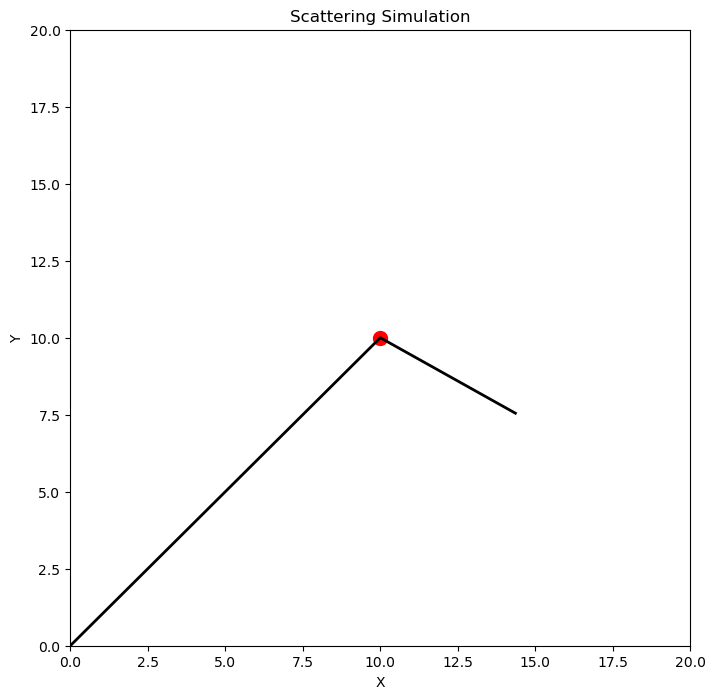

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# 入射粒子的初始角度
theta_i = 0

# 散射中心的位置
x_c = 10
y_c = 10

# 散射中心的半径
r_c = 5

# 散射角度的范围
theta_min = -np.pi/2
theta_max = np.pi/2
# 生成随机的散射角度
theta_s = np.random.uniform(theta_min, theta_max)
# 计算散射后粒子的位置
x_f = x_c + r_c * np.cos(theta_s)
y_f = y_c + r_c * np.sin(theta_s)
# 绘制散射过程的示意图
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, x_c, x_f], [0, y_c, y_f], 'k-', lw=2)
ax.scatter(x_c, y_c, color='r', s=100)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scattering Simulation')
plt.show()

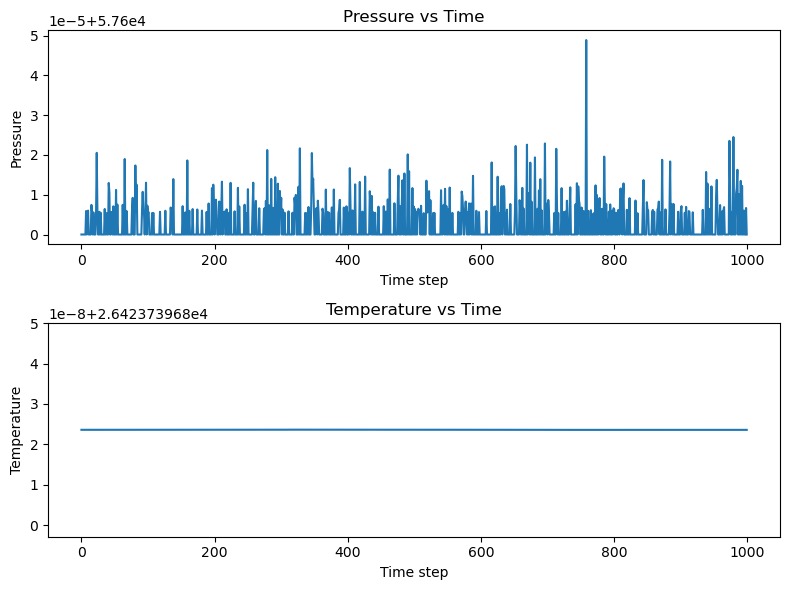

In [7]:
import numpy as np
import os
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# 設置模擬參數
N = 6 ** 3  # 分子數量
L = 50.0  # 模擬空間邊長
m = 1  # 分子質量
T = 300.0  # 初始溫度
dt = 0.005  # 時間步長
num_steps = 1000  # 模擬步數
r = 0.5  # 分子半徑
kb = 1.38e-23  # Boltzmann 常數

# 初始化分子位置和速度
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
pos = np.array([[x * d - L / 2 + d / 2, y * d - L / 2 + d / 2, z * d - L / 2 + d / 2]
                for x in range(n) for y in range(n) for z in range(n)])[:N]
vel = np.random.normal(0, np.sqrt(kb * T / m), size=(N, 3)) * 10 ** 11*10
total_momentum = np.sum(vel, axis=0)
vel -= total_momentum / N

# 定義碰撞函數
def elastic_collision(v1, v2, m1=m, m2=m):
    v1_new = v1 - (2 * m2 / (m1 + m2)) * np.dot(v1 - v2, v1 - v2) / \
        np.linalg.norm(v1 - v2) ** 2 * (v1 - v2)
    v2_new = v2 - (2 * m1 / (m1 + m2)) * np.dot(v2 - v1, v2 - v1) / \
        np.linalg.norm(v2 - v1) ** 2 * (v2 - v1)
    return v1_new, v2_new

# 計算壓強
def calculate_pressure(pos, vel, m, L, N, kb, T):
    # 計算動量
    momentum = np.sum(m * vel, axis=0)
    
    # 計算動能
    kinetic_energy = 0.5 * m * np.sum(vel ** 2/10**22)
    
    # 計算位能
    distances = cdist(pos, pos)
    potential_energy = np.sum(m * m / np.maximum(distances[distances < 2 * r], 1e-8))
    
    # 計算壓強
    pressure = (2 * kinetic_energy + potential_energy) / (3 * L ** 3)
    
    return pressure

# 計算溫度
def calculate_temperature(vel, m, N, kb):
    kinetic_energy = 0.5 * m * np.sum(vel ** 2/10**22)
    temperature = 2 * kinetic_energy / (3 * N * kb)
    return temperature

# 模擬分子運動並輸出資料
if not os.path.exists('molecular_dynamics'):
    os.makedirs('molecular_dynamics')

pressures = []
temperatures = []

with open('molecular_dynamics/data.xyz', 'w') as f:
    for step in range(num_steps):
        pos += vel * dt
        mask = np.abs(pos) > L / 2 - r
        vel[mask] = -vel[mask]
        pos[mask] = np.sign(pos[mask]) * (L / 2 - r)
        distances = cdist(pos, pos)
        for i in range(N):
            for j in range(i + 1, N):
                if distances[i, j] < 2 * r:
                    vel[i], vel[j] = elastic_collision(vel[i], vel[j])
        pressure = calculate_pressure(pos, vel, m, L, N, kb, T)
        temperature = calculate_temperature(vel, m, N, kb)
        pressures.append(pressure)
        temperatures.append(temperature)
        f.write(f"{N}\nFrame {step}\n")
        for i in range(N):
            f.write(f"Ar {pos[i, 0]:.4f} {pos[i, 1]:.4f} {pos[i, 2]:.4f}\n")

# 繪圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(pressures)
ax1.set_xlabel('Time step')
ax1.set_ylabel('Pressure')
ax1.set_title('Pressure vs Time')

ax2.plot(temperatures)
ax2.set_xlabel('Time step')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature vs Time')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'matlab.engine'; 'matlab' is not a package